In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Normalize, ToTensor, Compose
from tensorflow.keras.metrics import MeanIoU

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
!pip install segmentation_models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.0 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [5]:
img_dataset=[]
msk_dataset=[]

path="/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"
root, tile, filepaths=next(os.walk(path))

for t in tile:
    tile_dir= root+"/"+t
    _, typ, _=next(os.walk(tile_dir))
    image_dir = tile_dir+"/"+typ[0]
    mask_dir = tile_dir+"/"+typ[1]
    for i in range(9):
        img_dataset.append(f"{image_dir}/image_part_00{i+1}.jpg")
        msk_dataset.append(f"{mask_dir}/image_part_00{i+1}.png")

In [6]:
def reshape_img(imgpath):
    img=Image.open(imgpath).convert("RGB")
    new=img.resize((512,512),PIL.Image.NEAREST)
    new1=np.array(new)
    return new1

In [7]:
print(img_dataset[5])

/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_006.jpg


Image Type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Mask Type: <class 'PIL.PngImagePlugin.PngImageFile'>
Image Size: (1817, 2062)
Image Shape: (2062, 1817, 3) Mask Shape: (2062, 1817, 3)
Image Data Type: uint8
Mask Data Type: uint8


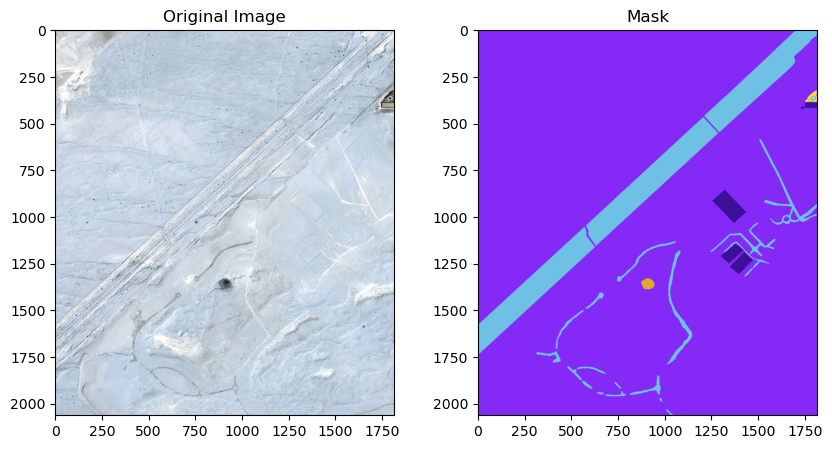

In [8]:
img= Image.open(img_dataset[5])
msk= Image.open(msk_dataset[5])


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(msk)


print("Image Type:", type(img))
print("Mask Type:", type(msk))
print("Image Size:",img.size)
print("Image Shape:", np.array(img).shape, "Mask Shape:", np.array(msk).shape)
print("Image Data Type:", np.array(img).dtype)
print("Mask Data Type:", np.array(msk).dtype)

In [9]:
image_data=np.zeros((72,512,512,3))
mask_data=np.zeros((72,512,512,3))
for i in range(72):
    img_path=img_dataset[i]
    img=reshape_img(img_path)
    image_data[i] = img
    
    msk_path= msk_dataset[i]
    msk= reshape_img(msk_path)
    mask_data[i] = msk

In [10]:
X_train, X_test, y_train, y_test = train_test_split(image_data, mask_data, test_size=0.2, random_state=42)

In [11]:
print(len(X_train), len(y_train))

57 57


In [12]:
from keras.metrics import MeanIoU

In [23]:
BACKBONE = 'resnet34'
preprocess_input = segmentation_models.get_preprocessing(BACKBONE)
metrics=['accuracy',jacard_coef]
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = segmentation_models.Unet(BACKBONE, encoder_weights='imagenet', classes=3, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)

optim = tf.keras.optimizers.Adam(learning_rate=0.00005,name='adam')
model_resnet_backbone.compile(optimizer=optim, loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_102 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                          

In [24]:
history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/50
8/8 [==============================] - 27s 519ms/step - loss: 545.2950 - accuracy: 0.4915 - jacard_coef: 0.5259 - val_loss: 484.5519 - val_accuracy: 0.5741 - val_jacard_coef: 0.5625
Epoch 2/50
8/8 [==============================] - 2s 261ms/step - loss: 528.3047 - accuracy: 0.5214 - jacard_coef: 0.5370 - val_loss: 550.7548 - val_accuracy: 0.6201 - val_jacard_coef: 0.6057
Epoch 3/50
8/8 [==============================] - 2s 259ms/step - loss: 513.3129 - accuracy: 0.5655 - jacard_coef: 0.5481 - val_loss: 641.2635 - val_accuracy: 0.6565 - val_jacard_coef: 0.6476
Epoch 4/50
8/8 [==============================] - 2s 259ms/step - loss: 505.2911 - accuracy: 0.5966 - jacard_coef: 0.5562 - val_loss: 837.8679 - val_accuracy: 0.6670 - val_jacard_coef: 0.6786
Epoch 5/50
8/8 [==============================] - 2s 262ms/step - loss: 501.0067 - accuracy: 0.6153 - jacard_coef: 0.5473 - val_loss: 983.0594 - val_accuracy: 0.6687 - val_jacard_coef: 0.6895
Epoch 6/50
8/8 [=======================

In [21]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection +1.)/(tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection +1.)

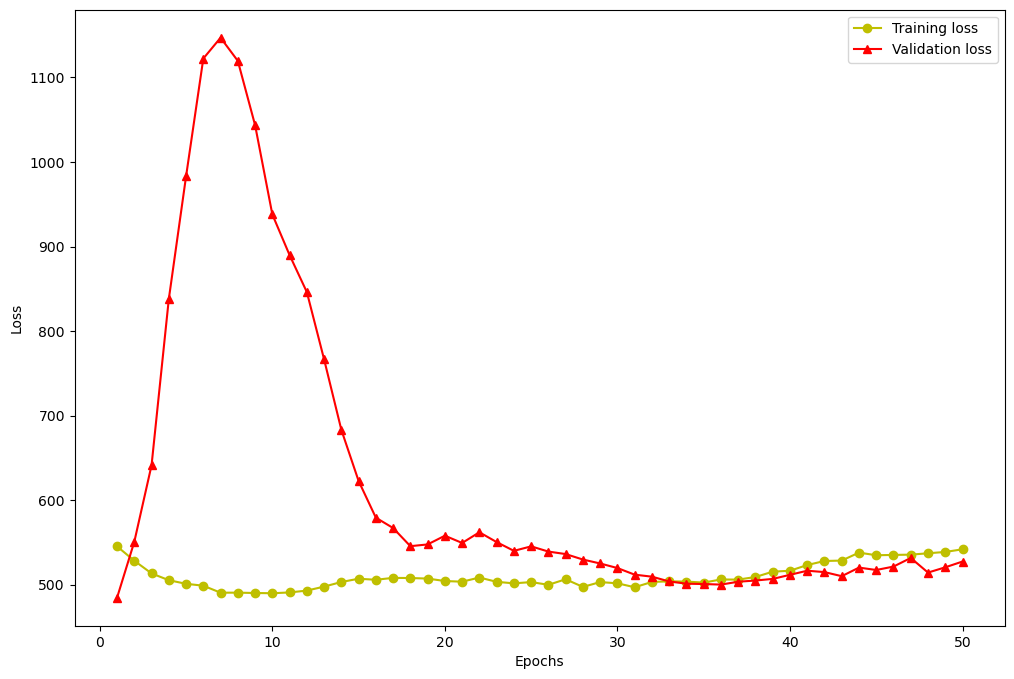

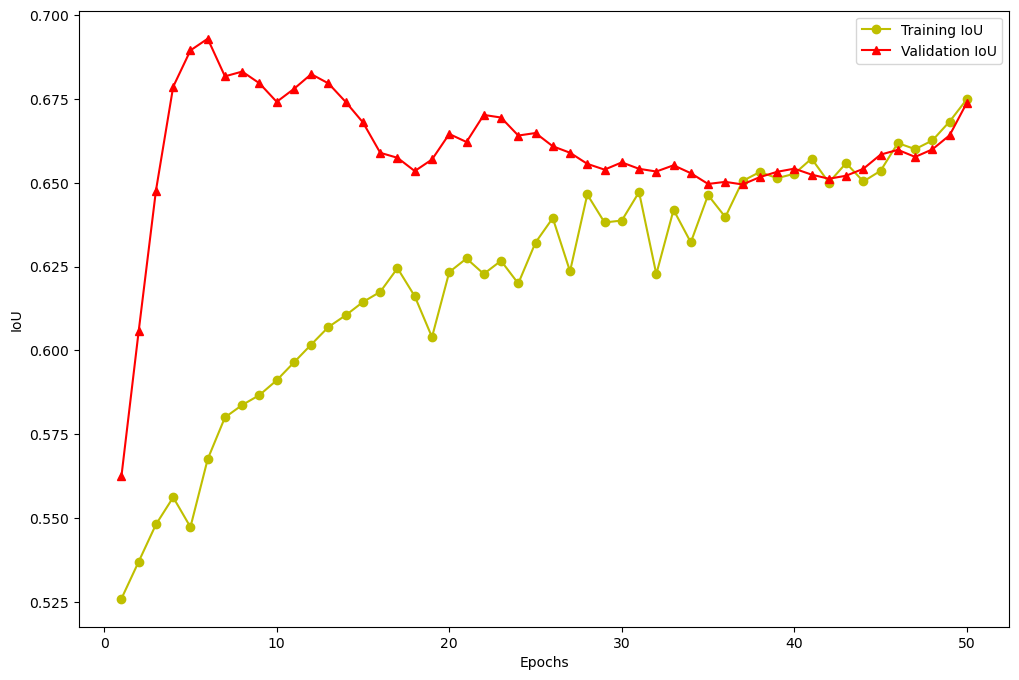

In [25]:
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss',marker='o')
plt.plot(epochs, val_loss, 'r', label='Validation loss',marker='^')
# plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']
plt.figure(figsize=(12,8))
plt.plot(epochs, acc, 'y', label='Training IoU',marker='o')
plt.plot(epochs, val_acc, 'r', label='Validation IoU',marker='^')
# plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()